# Exploring Jane Addams Letters 1901-1927

### MATH-390 | 01 | ADV TOPICS: NETWORK SCIENCE | Professor Beecher

### Tina Nosrati
### 11/30/2024


In [1]:
#packages
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors


# Data Preprocessing

In [2]:
#loading text processing essentials
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#defining text procesign functions
def remove_signs(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

def lowercase_text(text):
    return text.lower()

def remove_stopwords(text):
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

def apply_stemming(text):
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in tokens])

def apply_lemmatization(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

def preprocess_text(text):
    text = remove_signs(text)
    text = lowercase_text(text)
    text = remove_stopwords(text)
    text = apply_stemming(text)
    text = apply_lemmatization(text)
    return text

In [4]:
#reading the data and keeping the necessary columns
df=pd.read_csv("dataset.csv")
df.head()
df_text=df[['Identifier','Title','Subject','Date','Text', 'locations', 'tags']]
df_text=df_text.dropna()
#apply test preprocesing
df_text['Text'] = df_text['Text'].apply(preprocess_text)


In [ ]:
#saving cleaned data
df_text.to_csv("cleaned_data.csv")

# Dividing datasets

In [8]:
df_text['Date'] = pd.to_datetime(df_text['Date'], errors='coerce', utc=True)

df_text = df_text.dropna(subset=['Date'])

df_text['Date'] = df_text['Date'].dt.tz_convert(None)

df_1901_1909 = df_text[(df_text['Date'].dt.year >= 1901) & (df_text['Date'].dt.year <= 1909)]
df_1910_1919 = df_text[(df_text['Date'].dt.year >= 1910) & (df_text['Date'].dt.year <= 1919)]
df_1920_1927 = df_text[(df_text['Date'].dt.year >= 1920) & (df_text['Date'].dt.year <= 1927)]

In [9]:
df_1901_1909.to_csv('df_1901_1909.csv')
df_1910_1919.to_csv('df_1910_1919.csv')
df_1920_1927.to_csv('df_1920_1927.csv')

# Network Analysis Functions

### Vectorization and cosine similarity

In [48]:
#TFIDF vectorization and cosine similarity
def TFIDF(df):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=df.index, columns=df.index)
    #cosine_sim_df.head()
    return cosine_sim_df


### Similarity stat

In [49]:
#similarity stats
def sim_stat(similarity_matrix):
    similarity_matrix = np.array(similarity_matrix)
    np.fill_diagonal(similarity_matrix, np.nan)
    
    min_val = np.nanmin(similarity_matrix)
    max_val = np.nanmax(similarity_matrix)
    mean_val = np.nanmean(similarity_matrix)
    std_dev = np.nanstd(similarity_matrix)
    
    print(f"Minimum similarity (excluding diagonal): {min_val:.4f}")
    print(f"Maximum similarity (excluding diagonal): {max_val:.4f}")
    print(f"Mean similarity (excluding diagonal): {mean_val:.4f}")
    print(f"Standard Deviation of similarity (excluding diagonal): {std_dev:.4f}")
    
    return mean_val, std_dev

### Finding the threshold


#### T= mean similarity + k * standard deviation similarity

In [50]:
#estimate the best k value
def find_k(cossimilarity_matrix,mean_val, std_dev):
    upper_tri_matrix = np.triu(cossimilarity_matrix, k=1)
    similarity_scores = upper_tri_matrix[upper_tri_matrix != 0]
    k_values = np.linspace(0, 10, 20) 
    retained_ratios = []

    for k in k_values:
        threshold = mean_val + k * std_dev
        retained = similarity_scores[similarity_scores > threshold]
        retained_ratio = len(retained) / len(similarity_scores)
        retained_ratios.append(retained_ratio)

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, retained_ratios, marker='o')
    plt.title("Retained Similarities vs k")
    plt.xlabel("k Value")
    plt.ylabel("Retained Ratio")
    plt.grid()
    plt.show()

### Plot the network

In [51]:
#plot
def plot_network(similarity_df):
    G = nx.from_pandas_edgelist(similarity_df, source='Letter_A', target='Letter_B', edge_attr='Similarity')
    pos = nx.spring_layout(G, seed=42, k=0.8) 
    weights = [d['Similarity'] for _, _, d in G.edges(data=True)]
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = plt.cm.viridis(norm(weights))

    plt.figure(figsize=(20, 15))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=colors, width=2, node_size=200, font_size=3, font_weight='bold')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Similarity', fontsize=12)

    plt.title("Graph Visualization of the Similarity Network")
    plt.show()

# Network Analysis Complete 

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 1.0000
Mean similarity (excluding diagonal): 0.0493
Standard Deviation of similarity (excluding diagonal): 0.0334


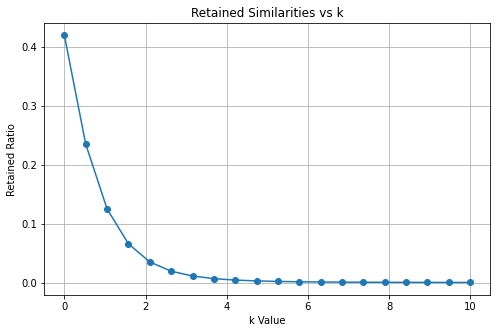

Similarity Threshold: 0.21624081659136024
       Letter_A  Letter_B  Similarity
8341       1316      1746    1.000000
14761      2867      3061    1.000000
8646       1365      1463    1.000000
12294      1874      1955    0.995130
9518       1431      1436    0.992041
...         ...       ...         ...
1365        164       467    0.216254
12125      1831      2455    0.216250
122          20       689    0.216249
12750      1990      1994    0.216247
2514        297       854    0.216244

[16402 rows x 3 columns]


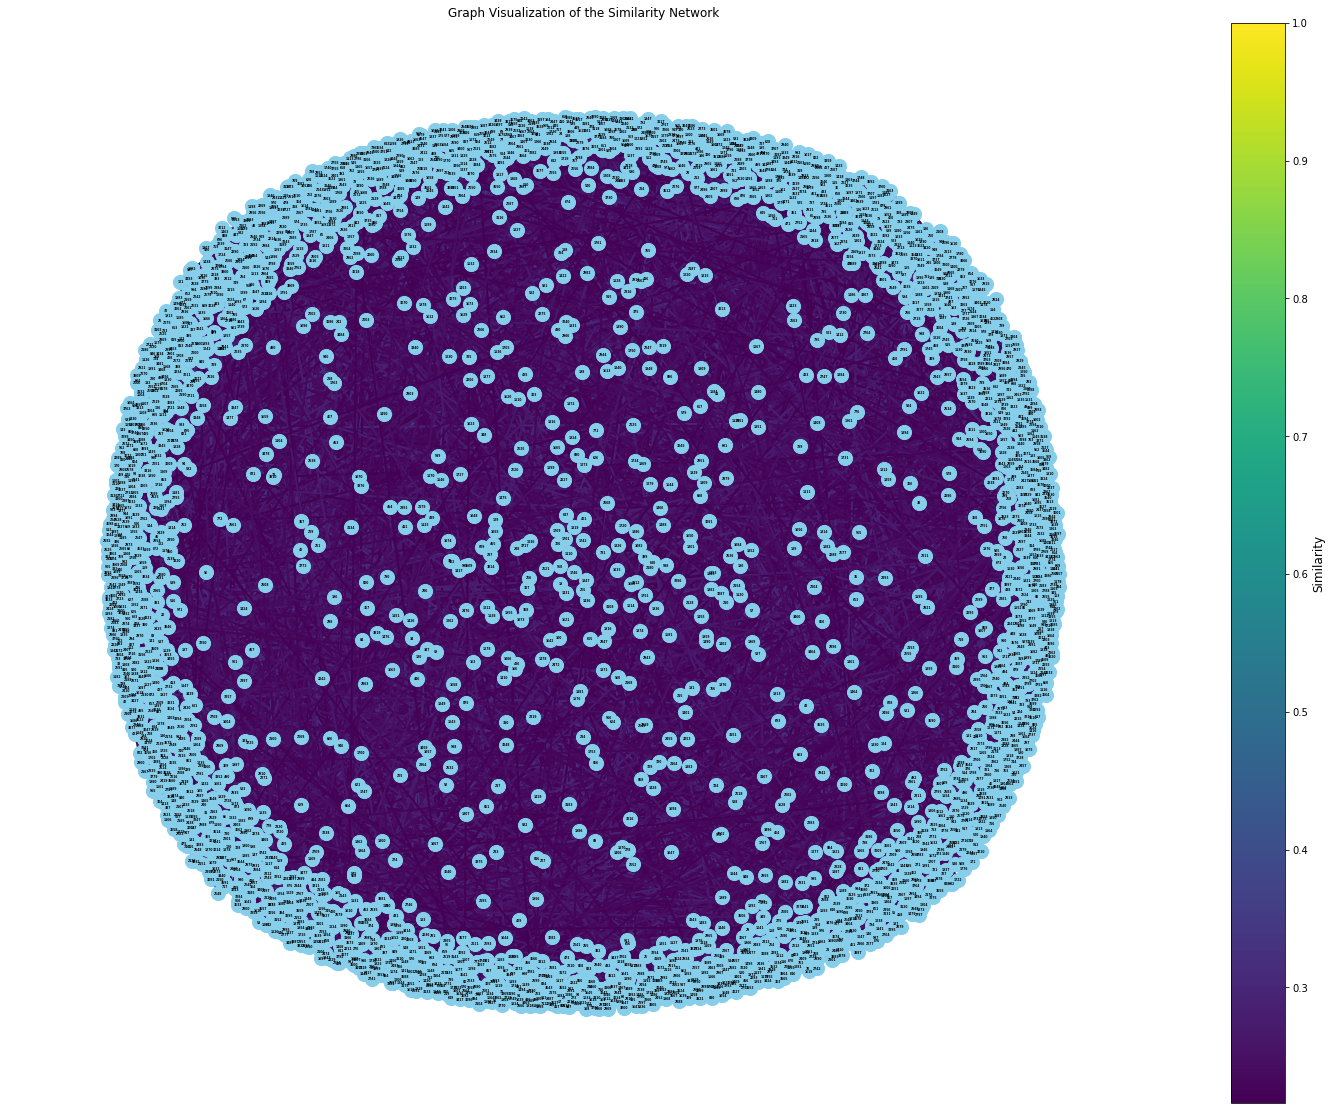

In [52]:
#full dataset
cosine_sim_df=TFIDF(df_text)
mean, std = sim_stat(cosine_sim_df)
find_k(cosine_sim_df,mean,std)
k=5
similarity_threshold = mean + k * std
print("Similarity Threshold:", similarity_threshold)
cosine_sim_df = pd.DataFrame(cosine_sim_df)
mask = (cosine_sim_df > similarity_threshold) & np.triu(np.ones(cosine_sim_df.shape), k=1).astype(bool)
similarity_df = cosine_sim_df.where(mask).stack().reset_index()
similarity_df.columns = ['Row1', 'Row2', 'Similarity']
similarity_df = similarity_df.sort_values(by='Similarity', ascending=False)
similarity_df.rename(columns={similarity_df.columns[0]: 'Letter_A', similarity_df.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df)
plot_network(similarity_df)
similarity_df.to_csv("similarity_df_complete.csv")


# Network Analysis 1901-1909 

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 0.9680
Mean similarity (excluding diagonal): 0.0562
Standard Deviation of similarity (excluding diagonal): 0.0347


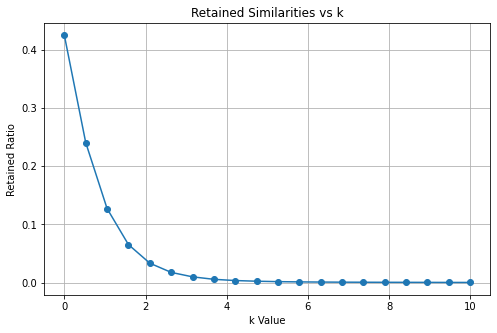

Similarity Threshold: 0.22977037214191004
     Letter_A  Letter_B  Similarity
22       3131      3835    0.968023
235      3497      3510    0.890682
5        2379      3164    0.869470
224      3477      3493    0.856450
382      3821      3822    0.836515
..        ...       ...         ...
103      3339      3476    0.230564
261      3537      3743    0.230559
227      3478      3484    0.230548
71       3254      3345    0.230254
112      3343      3518    0.230142

[406 rows x 3 columns]


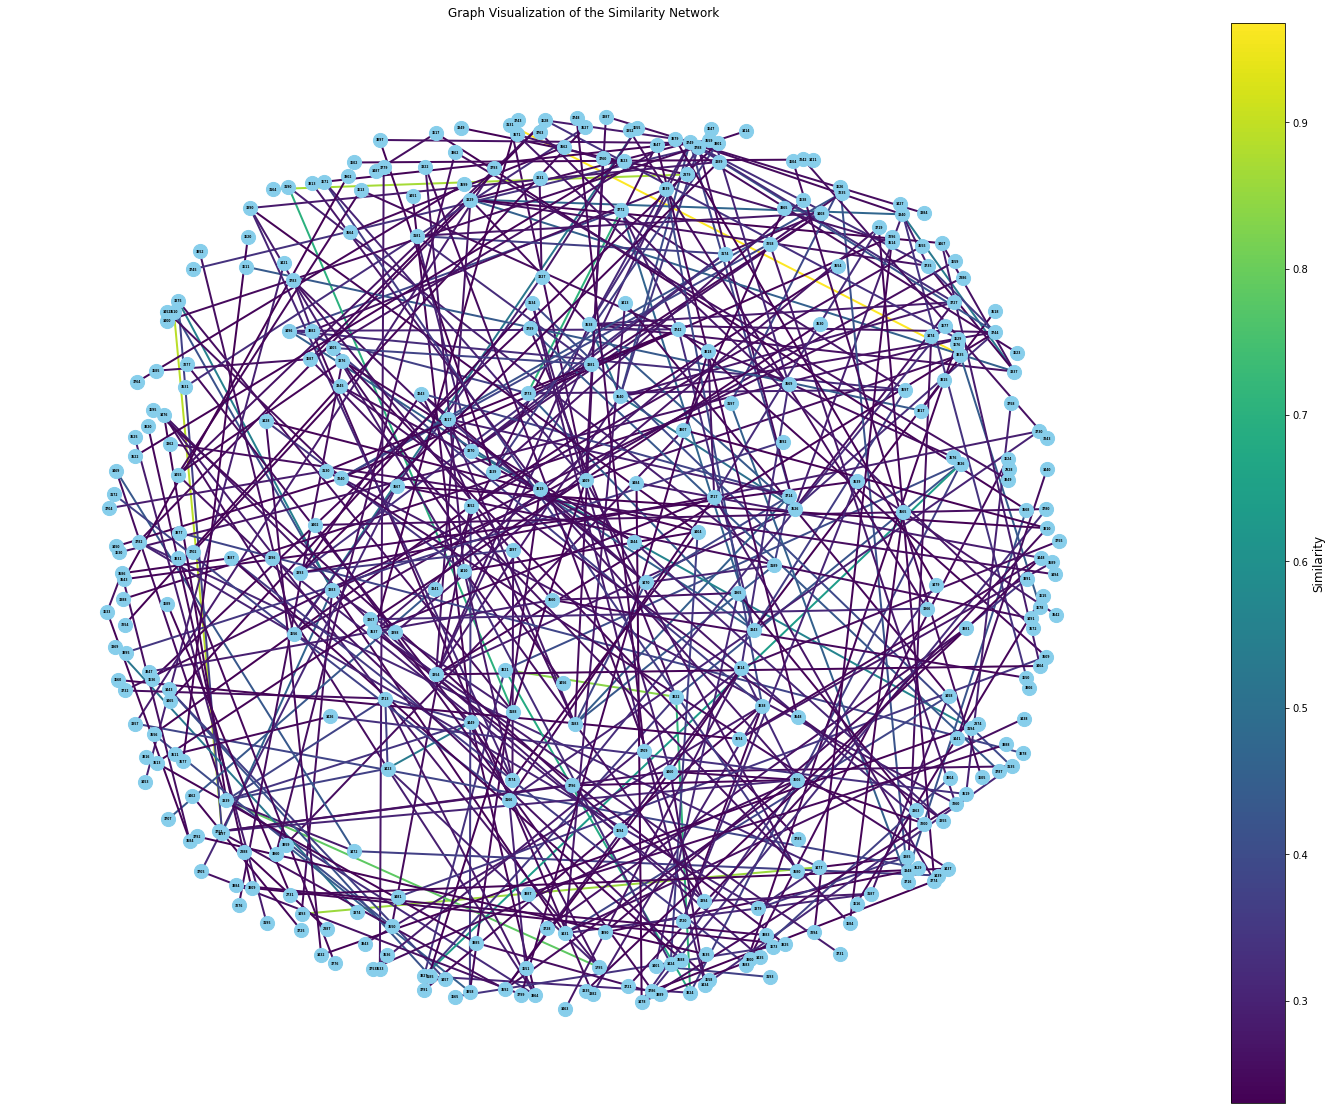

In [53]:
#1901-1909
cosine_sim_df_1901_1909=TFIDF(df_1901_1909)
mean_1901_1909, std_1901_1909 = sim_stat(cosine_sim_df_1901_1909)
find_k(cosine_sim_df_1901_1909,mean_1901_1909,std_1901_1909)
k=5
similarity_threshold_1901_1909 = mean_1901_1909 + k * std_1901_1909
print("Similarity Threshold:", similarity_threshold_1901_1909)
cosine_sim_df_1901_1909 = pd.DataFrame(cosine_sim_df_1901_1909)
mask = (cosine_sim_df_1901_1909 > similarity_threshold_1901_1909) & np.triu(np.ones(cosine_sim_df_1901_1909.shape), k=1).astype(bool)
similarity_df_1901_1909 = cosine_sim_df_1901_1909.where(mask).stack().reset_index()
similarity_df_1901_1909.columns = ['Row1', 'Row2', 'Similarity']
similarity_df_1901_1909 = similarity_df_1901_1909.sort_values(by='Similarity', ascending=False)
similarity_df_1901_1909.rename(columns={similarity_df_1901_1909.columns[0]: 'Letter_A', similarity_df_1901_1909.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df_1901_1909)
plot_network(similarity_df_1901_1909)
similarity_df_1901_1909.to_csv("similarity_df_1901_1909.csv")


# Network Analysis Complete 1910-1919

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 1.0000
Mean similarity (excluding diagonal): 0.0528
Standard Deviation of similarity (excluding diagonal): 0.0360


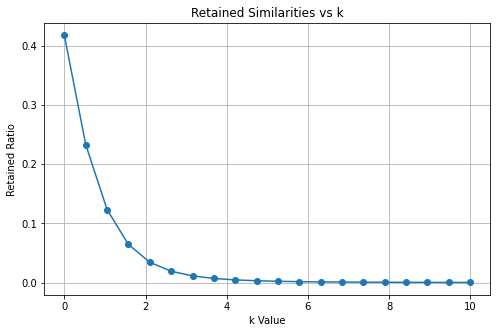

Similarity Threshold: 0.22977037214191004
      Letter_A  Letter_B  Similarity
650       1365      1463    1.000000
4536      2867      3061    1.000000
447       1316      1746    1.000000
3042      1874      1955    0.995390
1240      1431      1436    0.992528
...        ...       ...         ...
2428      1701      2538    0.232818
1435      1466      1770    0.232806
4106      2559      2592    0.232803
684       1370      1882    0.232802
1679      1510      1761    0.232802

[4932 rows x 3 columns]


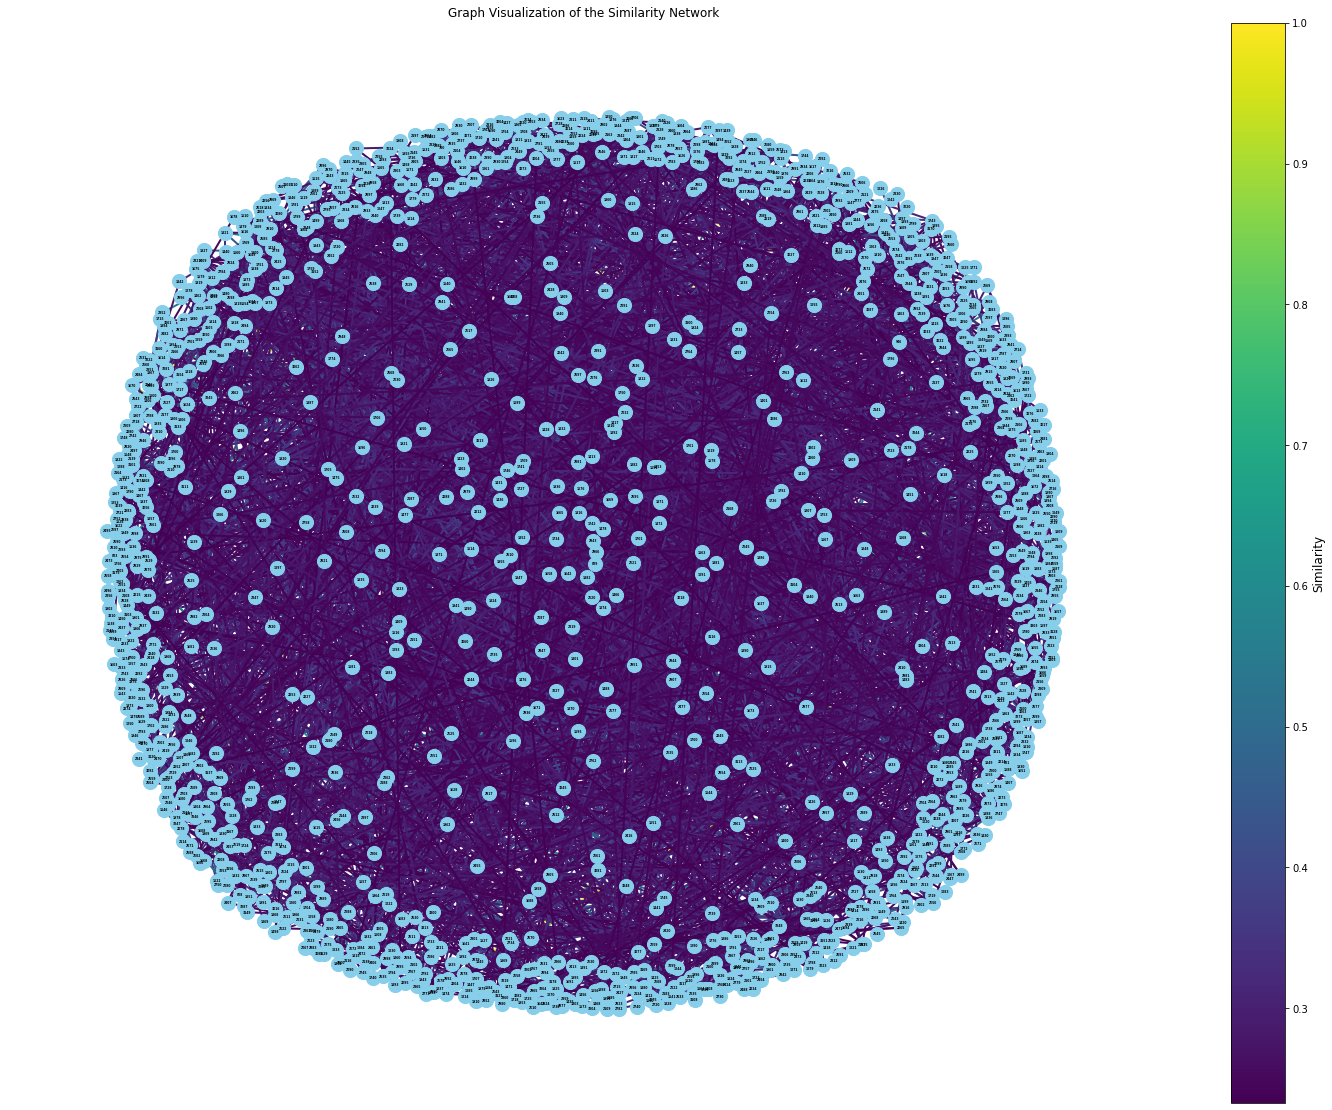

In [54]:
#1910-1919
cosine_sim_df_1910_1919=TFIDF(df_1910_1919)
mean_1910_1919, std_1910_1919 = sim_stat(cosine_sim_df_1910_1919)
find_k(cosine_sim_df_1910_1919,mean_1910_1919,std_1910_1919)
k=5
similarity_threshold_1910_1919 = mean_1910_1919 + k * std_1910_1919
print("Similarity Threshold:", similarity_threshold_1901_1909)
cosine_sim_df_1910_1919 = pd.DataFrame(cosine_sim_df_1910_1919)
mask = (cosine_sim_df_1910_1919 > similarity_threshold_1910_1919) & np.triu(np.ones(cosine_sim_df_1910_1919.shape), k=1).astype(bool)
similarity_df_1910_1919 = cosine_sim_df_1910_1919.where(mask).stack().reset_index()
similarity_df_1910_1919.columns = ['Row1', 'Row2', 'Similarity']
similarity_df_1910_1919 = similarity_df_1910_1919.sort_values(by='Similarity', ascending=False)
similarity_df_1910_1919.rename(columns={similarity_df_1910_1919.columns[0]: 'Letter_A', similarity_df_1910_1919.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df_1910_1919)
plot_network(similarity_df_1910_1919)
similarity_df_1910_1919.to_csv("similarity_df_1910_1919.csv")


# Network Analysis Complete 1920-1927

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 0.9879
Mean similarity (excluding diagonal): 0.0564
Standard Deviation of similarity (excluding diagonal): 0.0395


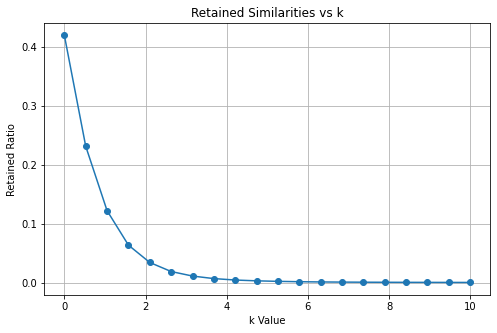

Similarity Threshold: 0.25398408814133666
      Letter_A  Letter_B  Similarity
1658      1219      1235    0.987939
1652      1202      1235    0.982475
1651      1202      1219    0.970475
1457       980       982    0.968975
556        252       255    0.966504
...        ...       ...         ...
822        425       430    0.254130
1490      1023      1056    0.254111
1416       939      1048    0.254077
1290       884       890    0.254026
1159       747       866    0.254004

[1660 rows x 3 columns]


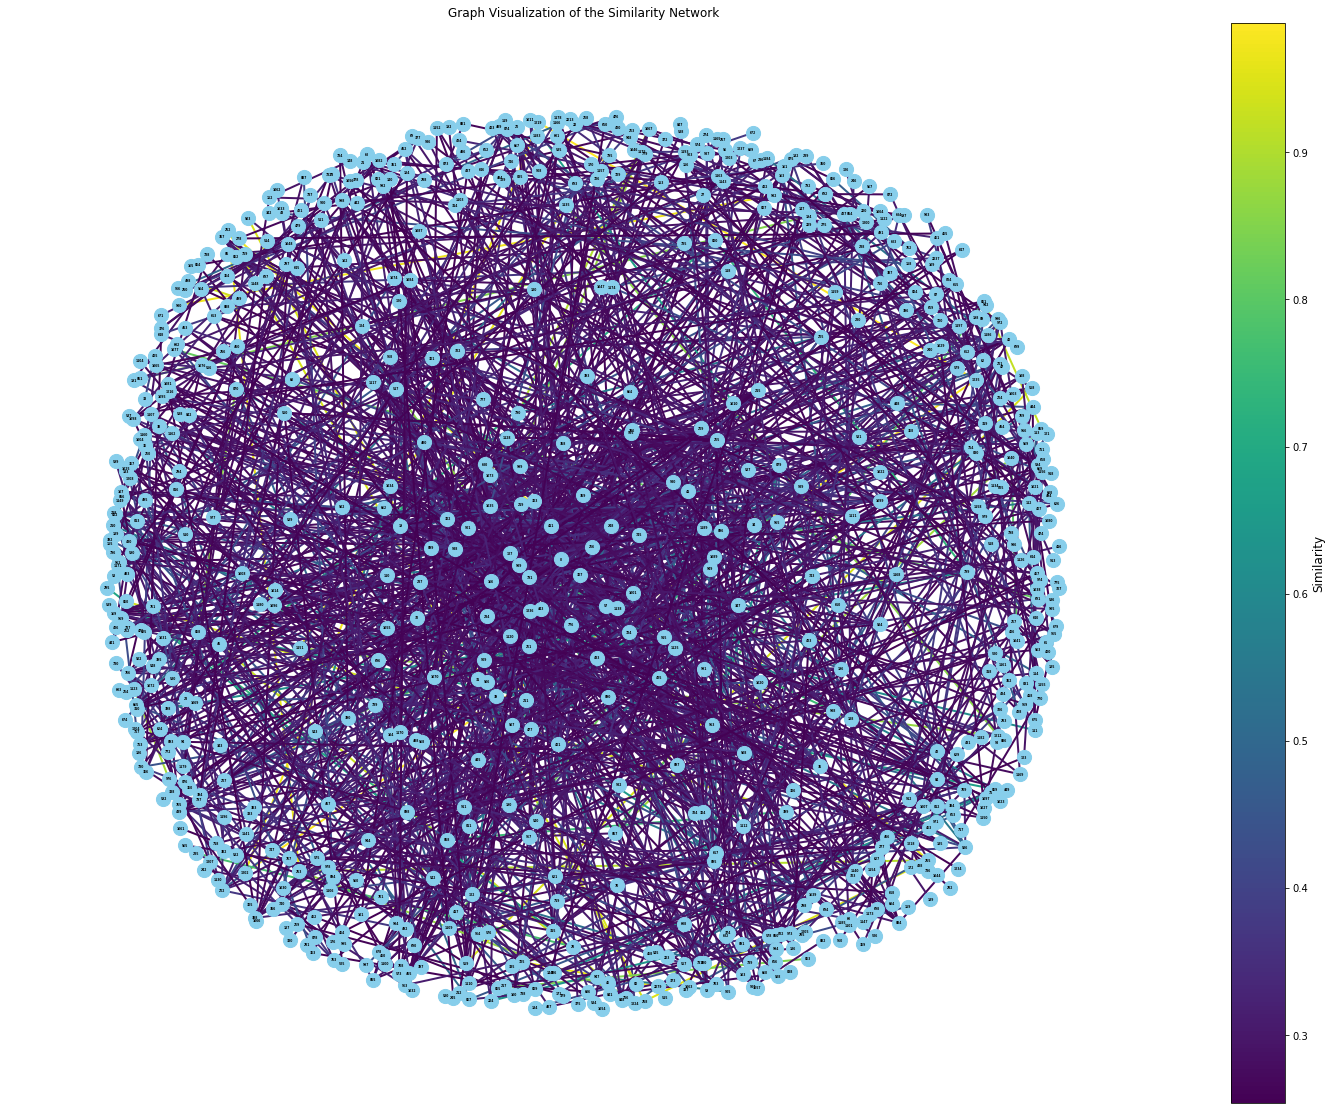

In [55]:
#1920-1927
cosine_sim_df_1920_1927=TFIDF(df_1920_1927)
mean_1920_1927, std_1920_1927 = sim_stat(cosine_sim_df_1920_1927)
find_k(cosine_sim_df_1920_1927,mean_1920_1927,std_1920_1927)
k=5
similarity_threshold_1920_1927 = mean_1920_1927 + k * std_1920_1927
print("Similarity Threshold:", similarity_threshold_1920_1927)
cosine_sim_df_1920_1927 = pd.DataFrame(cosine_sim_df_1920_1927)
mask = (cosine_sim_df_1920_1927 > similarity_threshold_1920_1927) & np.triu(np.ones(cosine_sim_df_1920_1927.shape), k=1).astype(bool)
similarity_df_1920_1927 = cosine_sim_df_1920_1927.where(mask).stack().reset_index()
similarity_df_1920_1927.columns = ['Row1', 'Row2', 'Similarity']
similarity_df_1920_1927 = similarity_df_1920_1927.sort_values(by='Similarity', ascending=False)
similarity_df_1920_1927.rename(columns={similarity_df_1920_1927.columns[0]: 'Letter_A', similarity_df_1920_1927.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df_1920_1927)
plot_network(similarity_df_1920_1927)
similarity_df_1920_1927.to_csv("similarity_df_1920_1927.csv")

